In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from mpi4py import MPI
import ufl
from dolfinx import io, fem
from dolfinx.cpp.nls.petsc import NewtonSolver
from dolfinx.common import list_timings, TimingType
from dolfinx_materials.quadrature_map import QuadratureMap
from dolfinx_materials.solvers import NonlinearMaterialProblem
from dolfinx_materials.jax_materials import (
    LinearElasticIsotropic,
    von_Mises_stress,
    Hosford_stress
)
from dolfinx_materials.jax_materials.tensors import dev, K
from dolfinx_materials.material.jax import JAXMaterial, tangent_AD, custom_timer
from dolfinx_materials.material.jax.jax_newton_solver import SolverParameters, newton_solve, _solve_linear_system
from functools import partial
from generate_mesh import generate_perforated_plate
from time import time

class JAXNewton:
    """A tiny Newton solver implemented in JAX. Derivatives are computed via custom implicit differentiation."""

    def __init__(self, rtol=1e-8, atol=1e-8, niter_max=2000, implicit_diff=True):
        """Newton solver for a vector of residual r(x).

        Parameters
        ----------
        r : callable, list, tuple
            Residual to solve for. r(x) is a function of R^n to R^n. Alternatively, r can be a list/tuple
            of functions with the same signature. The resulting system corresponds to a concatenation of all
            individual residuals.
        dr_dx : callable, optional
            The jacobian of the residual. dr_dx(x) is a function of R^n to R^{n}xR^n. If None (default),
            JAX computes the residual using forward-mode automatic differentiation.
        rtol : float, optional
            Relative tolerance for the Newton method, by default 1e-8
        atol : float, optional
            Absolute tolerance for the Newton method, by default 1e-8
        niter_max : int, optional
            Maximum number of allowed iterations, by default 200
        """
        self.params = SolverParameters(rtol, atol, niter_max)
        self.implicit_diff = implicit_diff

    def set_residual(self, r, dr_dx=None):
        # residual
        if isinstance(r, list) or isinstance(r, tuple):
            self.r = lambda *x: jnp.concatenate([jnp.atleast_1d(ri(*x)) for ri in r])
        else:
            self.r = r
        if dr_dx is None:
            self.dr_dx = jax.jit(jax.jacfwd(self.r))
        else:
            self.dr_dx = dr_dx

    @partial(jax.jit, static_argnums=(0,))
    def solve(self, x, aux=None):
        if self.implicit_diff:
            solve = lambda f, x: newton_solve(x, f, jax.jacfwd(f), self.params)
            tangent_solve = lambda g, y: _solve_linear_system(x, jax.jacfwd(g)(y), y)
            x_sol, data = jax.lax.custom_root(self.r, x, solve, tangent_solve, has_aux=True)
        else:
            # x_sol, data = solve(self.r, x)
            x_sol, data = newton_solve(x, lambda x: self.r(x, *aux), lambda x: self.dr_dx(x, *aux), self.params) 
        return x_sol, data


class vonMisesIsotropicHardening(JAXMaterial):
    def __init__(self, elastic_model, yield_stress, implicit_diff):
        super().__init__()
        self.elastic_model = elastic_model
        self.yield_stress = yield_stress
        self.equivalent_stress = von_Mises_stress
        self.implicit_diff = implicit_diff
        self.newton_solver = JAXNewton(implicit_diff=self.implicit_diff)

    @property
    def internal_state_variables(self):
        return {"p": 1, "niter": 1}

    @tangent_AD
    def constitutive_update(self, eps, state, dt):
        eps_old = state["Strain"]
        deps = eps - eps_old
        p_old = state["p"][0]  # convert to scalar
        sig_old = state["Stress"]

        mu = self.elastic_model.mu
        C = self.elastic_model.C
        sig_el = sig_old + C @ deps
        sig_Y_old = self.yield_stress(p_old)
        sig_eq_el = jnp.clip(self.equivalent_stress(sig_el), a_min=1e-8)
        n_el = dev(sig_el) / sig_eq_el
        yield_criterion = sig_eq_el - sig_Y_old

        def deps_p_elastic(dp):
            return jnp.zeros(6)

        def deps_p_plastic(dp):
            return 3 / 2 * n_el * dp  # n=n_el simplification due to radial return

        def deps_p(dp, yield_criterion):
            return jax.lax.cond(
                yield_criterion < 0.0,
                deps_p_elastic,
                deps_p_plastic,
                dp,
            )

        def r(dp):
            r_elastic = lambda dp: dp
            r_plastic = (
                lambda dp: sig_eq_el - 3 * mu * dp - self.yield_stress(p_old + dp)
            )
            return jax.lax.cond(yield_criterion < 0.0, r_elastic, r_plastic, dp)

        self.newton_solver.set_residual(r)
        dp, data = self.newton_solver.solve(0.0)

        sig = sig_el - 2 * mu * deps_p(dp, yield_criterion)

        state["Strain"] += deps
        state["p"] += dp
        state["Stress"] = sig
        state["niter"] = jnp.array([data[0]])
        return sig, state


class GeneralIsotropicHardening(JAXMaterial):

    def __init__(self, elastic_model, yield_stress, equivalent_stress, implicit_diff):
        super().__init__()
        self.elastic_model = elastic_model
        self.yield_stress = yield_stress
        self.equivalent_stress = equivalent_stress
        self.implicit_diff = implicit_diff
        self.newton_solver = JAXNewton(atol=1e-8, rtol=1e-8, niter_max=100, implicit_diff=self.implicit_diff)
        r_p, r_eps_p = self.setup_integrator()
        self.newton_solver.set_residual((r_p, r_eps_p), dr_dx=None)

    @property
    def internal_state_variables(self):
        return {"p": 1, "niter": 1}


E = 70e3
sig0 = 350.0
sigu = 500.0
b = 1e3
elastic_model = LinearElasticIsotropic(E=70e3, nu=0.3)
equivalent_stress = Hosford_stress

def yield_stress(p):
    return sig0 + (sigu - sig0) * (1 - jnp.exp(-b * p))
C = elastic_model.C
E = elastic_model.E

implicit_diff = False
newton_solver = JAXNewton(atol=1e-8, rtol=1e-8, niter_max=100, implicit_diff=implicit_diff)

def setup_integrator():

    @jax.jit
    def stress(deps, deps_p, sig_old, C):
        return sig_old + C @ (deps - dev(deps_p))

    normal = jax.jacfwd(equivalent_stress)

    @jax.jit
    def r_p(dx, deps, sig_old, p_old, yield_criterion, C):
        deps_p = dx[:-1]
        dp = dx[-1]
        sig_eq = equivalent_stress(stress(deps, deps_p, sig_old, C))
        r_elastic = lambda dp: dp
        r_plastic = lambda dp: sig_eq - yield_stress(p_old + dp)
        return jax.lax.cond(yield_criterion < 0.0, r_elastic, r_plastic, dp)

    @jax.jit
    def r_eps_p(dx, deps, sig_old, p_old, yield_criterion, C):
        deps_p = dx[:-1]
        dp = dx[-1]

        sig = stress(deps, deps_p, sig_old, C)
        n = normal(sig)
        r_elastic = lambda deps_p, dp: deps_p
        r_plastic = lambda deps_p, dp: deps_p - n * dp
        return jax.lax.cond(yield_criterion < 0.0, r_elastic, r_plastic, deps_p, dp)

    return r_p, r_eps_p

r_p, r_eps_p = setup_integrator()
newton_solver.set_residual((r_p, r_eps_p), dr_dx=None)


def constitutive_update(eps, state, dt):
    Tic = time()
    eps_old = state["Strain"]

    deps = eps - eps_old
    p_old = state["p"][0]  # convert to scalar
    sig_old = state["Stress"]

    sig_el = sig_old + C @ deps
    sig_Y_old = yield_stress(p_old)
    sig_eq_el = jnp.clip(equivalent_stress(sig_el), a_min=1e-8)
    yield_criterion = sig_eq_el - sig_Y_old

    x0 = jnp.zeros((7,))
    x, data = newton_solver.solve(x0, aux=(deps, sig_old, p_old, yield_criterion, C))
    x, data = newton_solver.solve(
        x0, aux=(deps, sig_old, p_old, yield_criterion, C)
    )
    # jax.debug.print("Newton time {d}", d=data[-1])
    depsp = x[:-1]
    dp = x[-1]

    sig = sig_old + C @ (deps - dev(depsp))
    state["Strain"] += deps
    state["p"] += dp
    state["Stress"] = sig
    state["niter"] = jnp.array([data[0]])
    # jax.debug.print("Total time {d}", d=time() - Tic)
    return C, state
    # return sig, state


batched_constitutive_update = jax.vmap(constitutive_update, in_axes=(0, 0, None))
# batched_constitutive_update = jax.jit(batched_constitutive_update)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
# %%
from dolfinx.common import timing, list_timings, TimingType, Timer


# material = GeneralIsotropicHardening(
#     elastic_model, yield_stress, von_Mises_stress, implicit_diff
# )
# material = vonMisesIsotropicHardening(
#     elastic_model, yield_stress, implicit_diff
# )


Nbatch = 100000
eps = 1e-2
Eps = np.vstack(([0,0,0,eps,1.3*eps, 0],) * Nbatch)
# material.set_data_manager(Nbatch)
# state = material.get_initial_state_dict()
state = {
    "p": np.zeros((Nbatch, 1)),
    "Stress": np.zeros((Nbatch, 6)),
    "Strain": np.zeros((Nbatch, 6)),
}
# state = {
#     "p": np.zeros((1,)),
#     "Stress": np.zeros((6,)),
#     "Strain": np.zeros(( 6,)),
# }
Sig = []

for t in np.linspace(0, 1.0, 4):
    tic = time()
    Ct, state = batched_constitutive_update(t*Eps, state, 0)
    nit = max(1, state["niter"][0,0])
    print(f"Batched time for batch size {Nbatch} per iteration = {(time()-tic)/nit}")
    # for i in range(10):
    #     constitutive_update(t*Eps[0,:], state, 0)
    # niter = isv[0, 1]
    # print(state)
    # Sig.append(np.copy(sig[0]))
    # material.data_manager.update()

# (
#     ncalls,
#     wall,
#     user,
# ) = timing("Integration")[0:3]
# average_time = (
#     user / ncalls
# )

Batched time for batch size 100000 per iteration = 3.7189717292785645
Batched time for batch size 100000 per iteration = 2.3484691778818765
Batched time for batch size 100000 per iteration = 2.2938742637634277
Batched time for batch size 100000 per iteration = 2.2984694639841714


In [3]:
print(wall, average_time)

NameError: name 'wall' is not defined

IndexError: list index out of range

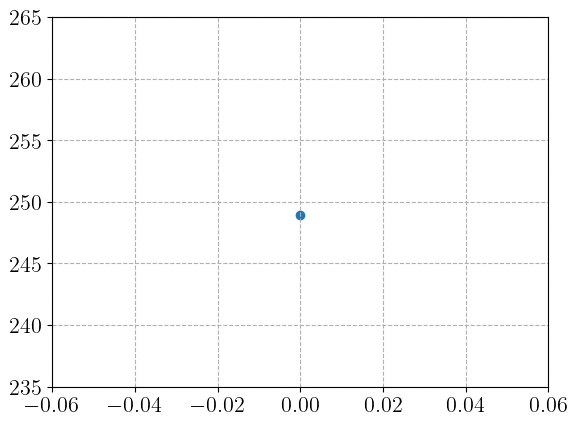

In [ ]:
for i in range(50):
    plt.scatter(i, Sig[i][3])

# %%
Lx = 1.0
Ly = 2.0
R = 0.2
mesh_sizes = (0.008, 0.2)
domain, markers, facets = generate_perforated_plate(Lx, Ly, R, mesh_sizes)
ds = ufl.Measure("ds", subdomain_data=facets)

# %%
order = 2
deg_quad = 2 * (order - 1)
shape = (2,)

V = fem.functionspace(domain, ("P", order, shape))
bottom_dofs = fem.locate_dofs_topological(V, 1, facets.find(1))
top_dofs = fem.locate_dofs_topological(V, 1, facets.find(2))

uD_b = fem.Function(V)
uD_t = fem.Function(V)
bcs = [fem.dirichletbc(uD_t, top_dofs), fem.dirichletbc(uD_b, bottom_dofs)]


def strain(u):
    return ufl.as_vector(
        [
            u[0].dx(0),
            u[1].dx(1),
            0.0,
            1 / np.sqrt(2) * (u[1].dx(0) + u[0].dx(1)),
            0.0,
            0.0,
        ]
    )


# %%
du = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
u = fem.Function(V)

# %%
qmap = QuadratureMap(domain, deg_quad, material)
qmap.register_gradient(material.gradient_names[0], strain(u))

# %%
sig = qmap.fluxes["Stress"]
Res = ufl.dot(sig, strain(v)) * qmap.dx
Jac = qmap.derivative(Res, u, du)

# %%
problem = NonlinearMaterialProblem(qmap, Res, Jac, u, bcs)
newton = NewtonSolver(MPI.COMM_WORLD)
newton.rtol = 1e-6
newton.atol = 1e-6
newton.convergence_criterion = "residual"
newton.max_it = 20

# %%

# out_file = "elastoplasticity.pvd"
# vtk = io.VTKFile(domain.comm, out_file, "w")

N = 15
Eyy = np.linspace(0, 7e-3, N + 1)
Syy = np.zeros_like(Eyy)
for i, eyy in enumerate(Eyy[1:]):
    uD_t.vector.array[1::2] = eyy * Ly

    converged, it = problem.solve(newton, print_solution=True)

    p = qmap.project_on("p", ("DG", 0))
    stress = qmap.project_on("Stress", ("DG", 0))

    Syy[i + 1] = fem.assemble_scalar(fem.form(stress[1] * ds(2))) / Lx

    # syy = stress.sub(1).collapse()
    # syy.name = "Stress"
    # vtk.write_function(u, i + 1)
    # vtk.write_function(p, i + 1)
    # vtk.write_function(syy, i + 1)

# %%
plt.figure()
plt.plot(Eyy, Syy, "-o")
plt.xlabel(r"Strain $\varepsilon_{yy}$")
plt.ylabel(r"Stress $\sigma_{yy}$")
# plt.savefig(f"{material.name}_stress_strain.pdf")
res = np.zeros((len(Eyy), 2))
res[:, 0] = Eyy
res[:, 1] = Syy
# np.savetxt(f"plasticity_results.csv", res, delimiter=",")

# %%